## Last test at Colab : 2022-04-26

## 한글



*   이론 :  https://wikidocs.net/164365 and https://wikidocs.net/164823  and https://wikidocs.net/164835 
*   구현 : https://wikidocs.net/165034  and https://wikidocs.net/164499 


## English


*   Theory : https://wikidocs.net/165403 and https://wikidocs.net/165405  and https://wikidocs.net/165406 
*   Implementation : https://wikidocs.net/165443  and https://wikidocs.net/165444 



### Below part is same with FFN.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
hidden_size = 256 
num_classes = 10
EPOCHS = 5
batch_size = 100
learning_rate = 0.001

In the case of Pytorch, CIFAR10 data can be easily loaded. Just change the dataset name as in the code below.

In [11]:
# CIFAR10 dataset 
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

Files already downloaded and verified


### Below part is same with FFN.

In [12]:
# Data loader
train_ds = torch.utils.data.DataLoader(dataset=train_dataset,
                                       batch_size=batch_size, 
                                       shuffle=True)

test_ds = torch.utils.data.DataLoader(dataset=test_dataset,
                                      batch_size=batch_size, 
                                      shuffle=False)

In [13]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

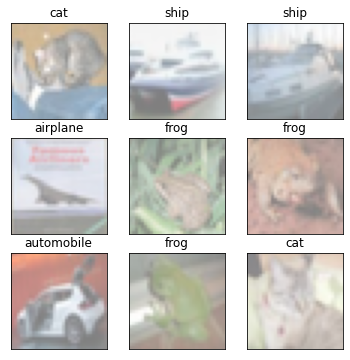

In [14]:
# Get one batch of training images
dataiter = iter(test_ds)
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(6, 6))

# Display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 9/3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In the case of CIFAR10, since there are 3 input channels, the number of input channels can be changed in parallel.

This is the part to be careful about when dealing with Pytorch. In the case of Pytorch, the number of input layers must be specified in the linear layer that comes after pooling. You can find out by printing out the structure of the created network, so you only need to pay attention to the benefits.

In [15]:
# 3-Layers Convolution neural network with one hidden layer
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool2d1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2d2 = nn.MaxPool2d(kernel_size=2)
        
        # Convolution 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        
        # Max pool 3
        self.maxpool2d3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.d1 = nn.Linear(256 * 2 * 2, 256) 
        self.d2 = nn.Dropout(0.2)
        self.d3 = nn.Linear(256, num_classes) 

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.relu1(x)
        
        # Max pool 1
        x = self.maxpool2d1(x)
        
        # Convolution 2 
        x = self.conv2(x)
        x = self.relu2(x)
        
        # Max pool 2 
        x = self.maxpool2d2(x)
        
        # Convolution 3
        x = self.conv3(x)
        x = self.relu3(x)
        
        # Max pool 3
        x = self.maxpool2d3(x)
        
        # Resize
        # Original size: (100, 256, 2, 2)
        # out.size(0): 100
        # New out size: (100, 256*2*2)
        x = x.view(x.size(0), -1)

        # Linear function (readout)
        x = self.d1(x)
        x = self.d2(x)
        out = self.d3(x)
        return out

### Below part is same with FFN.

In [16]:
# model = CNN_Model(input_size, hidden_size, num_classes).to(device)
model = CNN_Model().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_ds)

def train_step(model, images, labels):
    model.train()
    # origin shape: [100, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_val = loss.item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Pytorch need a manual coding for accuracy
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)           
    n_samples = labels.size(0)
    n_correct = (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    return loss_val, acc

def test_step(model, images, labels):
    model.eval()
    # origin shape: [100, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_val = loss.item()

    # Pytorch need a manual coding for accuracy
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)           
    n_samples = labels.size(0)
    n_correct = (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    return loss_val, acc

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(EPOCHS):
    
    with tqdm_notebook(total=len(train_ds), desc=f"Train Epoch {epoch+1}") as pbar:    
        train_losses = []
        train_accuracies = []
        
        for i, (images, labels) in enumerate(train_ds):
         
            loss_val, acc = train_step(model, images, labels)
            
            train_losses.append(loss_val)
            train_accuracies.append(acc)
            
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")


    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        
        with tqdm_notebook(total=len(test_ds), desc=f"Test_ Epoch {epoch+1}") as pbar:    
            test_losses = []
            test_accuracies = []

            for images, labels in test_ds:
                loss_val, acc = test_step(model, images, labels)

                test_losses.append(loss_val)
                test_accuracies.append(acc)

                pbar.update(1)
                pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")
            


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Train Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test_ Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Test_ Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]